In [ ]:
##############################################################################################################

In [2]:
import pandas as pd

# CSV ÌååÏùº Î∂àÎü¨Ïò§Í∏∞
df = pd.read_csv("../1stProject/data/Î™©Ï†ÅÎ≥Ñ_Íµ≠Ï†ÅÎ≥Ñ_ÏûÖÍµ≠.csv", encoding='cp949')

# "ÏÜå Í≥Ñ" Ìè¨Ìï®Îêú Ìñâ Ï†úÍ±∞
df_cleaned = df[~df.apply(lambda row: row.astype(str).str.contains("ÏÜå Í≥Ñ").any(), axis=1)]

# Í≤∞Í≥º Ï†ÄÏû•
df_cleaned.to_csv("../1stProject/data/Î™©Ï†ÅÎ≥Ñ_Íµ≠Ï†ÅÎ≥Ñ_ÏûÖÍµ≠_ÏÜåÍ≥ÑÏ†úÍ±∞.csv", index=False, encoding='cp949')

FileNotFoundError: [Errno 2] No such file or directory: '../1stProject/data/Î™©Ï†ÅÎ≥Ñ_Íµ≠Ï†ÅÎ≥Ñ_ÏûÖÍµ≠.csv'

In [ ]:
import pandas as pd

df = pd.read_excel("../1stProject/data/Î™©Ï†ÅÎ≥Ñ Íµ≠Ï†ÅÎ≥Ñ ÏûÖÍµ≠_250709084025.xls", engine="xlrd")
df.to_csv("../1stProject/data/Î™©Ï†ÅÎ≥Ñ_Íµ≠Ï†ÅÎ≥Ñ_ÏûÖÍµ≠.csv", index=False, encoding="cp949")


In [5]:
import pandas as pd
import numpy as np
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import platform

# [1] ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# [2] Îç∞Ïù¥ÌÑ∞ Î°úÎî© Î∞è Ï†ÑÏ≤òÎ¶¨
df = pd.read_csv('../1stProject/data/Î™©Ï†ÅÎ≥Ñ_Íµ≠Ï†ÅÎ≥Ñ_ÏûÖÍµ≠_ÏÜåÍ≥ÑÏ†úÍ±∞.csv', encoding='cp949')
df = df.melt(id_vars=["Íµ≠Ï†Å", "Î™©Ï†Å"], var_name="Ïõî", value_name="ÏûÖÍµ≠ÏûêÏàò")

# ‚õîÔ∏è "ÏûÖÍµ≠ÏûêÏàò"Ïóê Ïà´ÏûêÍ∞Ä ÏïÑÎãå Í∞í ÌïÑÌÑ∞ÎßÅ Ï†úÍ±∞
df = df[~df["ÏûÖÍµ≠ÏûêÏàò"].str.contains("Î™Ö|Ìï©Í≥Ñ|ÏÜåÍ≥Ñ|Ïù∏Ïõê", na=False)]

# ÎÇ†Ïßú Î∞è ÏàòÏπòÌòï Î≥ÄÌôò
df["Ïõî"] = pd.to_datetime(df["Ïõî"], format="%YÎÖÑ%mÏõî")
df["ÏûÖÍµ≠ÏûêÏàò"] = df["ÏûÖÍµ≠ÏûêÏàò"].astype(str).str.replace(",", "").astype(float)

# Í¥ÄÍ¥ë Î™©Ï†ÅÎßå ÌïÑÌÑ∞ÎßÅ
df = df[df["Î™©Ï†Å"] == "Í¥ÄÍ¥ë"].sort_values("Ïõî").reset_index(drop=True)

# [3] ProphetÏö© Îç∞Ïù¥ÌÑ∞
df_prophet = df.groupby("Ïõî")["ÏûÖÍµ≠ÏûêÏàò"].sum().reset_index()
df_prophet.columns = ["ds", "y"]

# [4] Prophet Î™®Îç∏ ÌõàÎ†® Î∞è ÏòàÏ∏°
prophet = Prophet(yearly_seasonality=True)
prophet.fit(df_prophet)
future = prophet.make_future_dataframe(periods=6, freq='MS')
forecast = prophet.predict(future)

# [5] XGBoostÏö© ÌîºÏ≤ò ÏÉùÏÑ±
df_feat = df_prophet.copy()
df_feat["Ïó∞ÎèÑ"] = df_feat["ds"].dt.year
df_feat["Ïõî"] = df_feat["ds"].dt.month
df_feat["Í≥ÑÏ†à"] = df_feat["Ïõî"] % 12 // 3
df_feat["Ï†ÑÏõîÏûÖÍµ≠ÏûêÏàò"] = df_feat["y"].shift(1)
df_feat["Ï†ÑÎÖÑÎèôÏõîÏûÖÍµ≠ÏûêÏàò"] = df_feat["y"].shift(12)
df_feat["Ï†ÑÏõîÏ¶ùÍ∞êÎ•†"] = df_feat["y"].pct_change().shift(1)
df_feat["Ï†ÑÎÖÑÏ¶ùÍ∞êÎ•†"] = (df_feat["y"] - df_feat["y"].shift(12)) / df_feat["y"].shift(12)
df_feat["Ïù¥ÎèôÌèâÍ∑†"] = df_feat["y"].rolling(window=3).mean().shift(1)
df_feat = df_feat.replace([np.inf, -np.inf], np.nan).dropna()

# [6] XGBoost Î™®Îç∏ ÌïôÏäµ Î∞è ÏòàÏ∏°
features = ["Ïó∞ÎèÑ", "Ïõî", "Í≥ÑÏ†à", "Ï†ÑÏõîÏûÖÍµ≠ÏûêÏàò", "Ï†ÑÎÖÑÎèôÏõîÏûÖÍµ≠ÏûêÏàò", "Ï†ÑÏõîÏ¶ùÍ∞êÎ•†", "Ï†ÑÎÖÑÏ¶ùÍ∞êÎ•†", "Ïù¥ÎèôÌèâÍ∑†"]
X = df_feat[features]
y = df_feat["y"]
X_train, X_test = X[:-6], X[-6:]
y_train, y_test = y[:-6], y[-6:]

model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=4, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, 0, None)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# [7] ÏãúÍ∞ÅÌôî
plt.figure(figsize=(14, 6))
plt.plot(df_feat["ds"], df_feat["y"], label="Ïã§Ï†ú ÏûÖÍµ≠ÏûêÏàò", color='blue')
plt.plot(forecast["ds"], forecast["yhat"], label="Prophet ÏòàÏ∏°", color='green', linestyle='--')
plt.plot(df_feat["ds"].iloc[-6:], y_pred, label="XGBoost ÏòàÏ∏°", color='orange', marker='o')
plt.axvline(df_feat["ds"].iloc[-7], color='gray', linestyle='--', label="ÏòàÏ∏° ÏãúÏûë")
plt.title(f"ÏûÖÍµ≠Ïûê Ïàò ÏòàÏ∏° (Prophet + XGBoost Î≥ëÎ†¨)\nXGBoost RMSE: {rmse:.0f}")
plt.xlabel("Ïõî")
plt.ylabel("ÏûÖÍµ≠Ïûê Ïàò")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


‚úÖ ÏÇ¨Ïö© Í∞ÄÎä•Ìïú Íµ≠Ï†Å Î™©Î°ù:


TypeError: '<' not supported between instances of 'str' and 'float'

In [3]:
# %pip install prophet xgboost

  Using cached prophet-1.1.7-py3-none-win_amd64.whl.metadata (3.6 kB)
  Using cached cmdstanpy-1.2.5-py3-none-any.whl.metadata (4.0 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached stanio-0.5.1-py3-none-any.whl.metadata (1.6 kB)
Using cached prophet-1.1.7-py3-none-win_amd64.whl (13.3 MB)
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 9.2 MB/s eta 0:00:00
Using cached cmdstanpy-1.2.5-py3-none-any.whl (94 kB)
Using cached stanio-0.5.1-py3-none-any.whl (8.1 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached importlib_resources-6.5.2-py3-none-any.whl (37 kB)

   ---------------------------------------- 0/6 [tqdm]
   ------------- -------------------------- 2/6 [importlib_resources]
   ------------- -------------------------- 2/6 [importlib_resources]
   -------------------- -------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
# GPU Ïù¥Ïö©
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib import rcParams

plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows ÌïúÍ∏Ä Ìè∞Ìä∏
plt.rcParams['axes.unicode_minus'] = False     # ÏùåÏàò Í∏∞Ìò∏ Íπ®Ïßê Î∞©ÏßÄ

# Î¨∏ÏûêÏó¥ Ï†ïÍ∑úÌôî Ìï®Ïàò
def normalize(text):
    return text.replace(" ", "").lower()

# [1] ÏÇ¨Ïö©Ïûê ÏûÖÎ†• Î∞è Ïú†ÏÇ¨ Îß§Ïπ≠
ÏÑ†ÌÉù_Íµ≠Ï†Å = input("ÏòàÏ∏°Ìï† Íµ≠Ï†Å ÏûÖÎ†• (Ï†ÑÏ≤¥ ÏòàÏ∏° ÏõêÌïòÎ©¥ Enter): ").strip()
ÏÑ†ÌÉù_Î™©Ï†Å = input("ÏòàÏ∏°Ìï† Î™©Ï†Å ÏûÖÎ†• (Ï†ÑÏ≤¥ ÏòàÏ∏° ÏõêÌïòÎ©¥ Enter): ").strip()

# [2] Îç∞Ïù¥ÌÑ∞ Î°úÎî© Î∞è Ï†ÑÏ≤òÎ¶¨
df = pd.read_csv('../1stProject/data/Î™©Ï†ÅÎ≥Ñ_Íµ≠Ï†ÅÎ≥Ñ_ÏûÖÍµ≠_ÏÜåÍ≥ÑÏ†úÍ±∞.csv', encoding='cp949')
df = df.melt(id_vars=["Íµ≠Ï†Å", "Î™©Ï†Å"], var_name="Ïõî", value_name="ÏûÖÍµ≠ÏûêÏàò")
df["Ïõî"] = pd.to_datetime(df["Ïõî"], format="%YÎÖÑ%mÏõî")
df["ÏûÖÍµ≠ÏûêÏàò"] = pd.to_numeric(df["ÏûÖÍµ≠ÏûêÏàò"].astype(str).str.replace(",", "", regex=False), errors="coerce")

# [3] Ïú†ÏÇ¨ Íµ≠Ï†Å/Î™©Ï†Å ÏûêÎèô ÏôÑÏÑ±
if ÏÑ†ÌÉù_Íµ≠Ï†Å:
    match = [nat for nat in df["Íµ≠Ï†Å"].dropna().unique()
             if isinstance(nat, str) and normalize(ÏÑ†ÌÉù_Íµ≠Ï†Å) in normalize(nat)]
    if match:
        ÏÑ†ÌÉù_Íµ≠Ï†Å = match[0]
        print(f"üëâ ÏûÖÎ†•Ìïú Íµ≠Ï†ÅÍ≥º Ïú†ÏÇ¨Ìïú Í∞íÏúºÎ°ú '{ÏÑ†ÌÉù_Íµ≠Ï†Å}' ÏÇ¨Ïö©")
    else:
        print("‚ùå Ïú†Ìö®Ìïú Íµ≠Ï†ÅÏù¥ ÏïÑÎãôÎãàÎã§."); ÏÑ†ÌÉù_Íµ≠Ï†Å = ""

if ÏÑ†ÌÉù_Î™©Ï†Å:
    match = [pur for pur in df["Î™©Ï†Å"].dropna().unique()
             if isinstance(pur, str) and normalize(ÏÑ†ÌÉù_Î™©Ï†Å) in normalize(pur)]
    if match:
        ÏÑ†ÌÉù_Î™©Ï†Å = match[0]
        print(f"üëâ ÏûÖÎ†•Ìïú Î™©Ï†ÅÍ≥º Ïú†ÏÇ¨Ìïú Í∞íÏúºÎ°ú '{ÏÑ†ÌÉù_Î™©Ï†Å}' ÏÇ¨Ïö©")
    else:
        print("‚ùå Ïú†Ìö®Ìïú Î™©Ï†ÅÏù¥ ÏïÑÎãôÎãàÎã§."); ÏÑ†ÌÉù_Î™©Ï†Å = ""

# [4] ÏòàÏ∏° ÎåÄÏÉÅ ÌïÑÌÑ∞ÎßÅ
targets = df.groupby(["Íµ≠Ï†Å", "Î™©Ï†Å"]).size().reset_index().rename(columns={0: "count"})
valid_targets = targets[targets['count'] > 24]
if ÏÑ†ÌÉù_Íµ≠Ï†Å:
    valid_targets = valid_targets[valid_targets["Íµ≠Ï†Å"] == ÏÑ†ÌÉù_Íµ≠Ï†Å]
if ÏÑ†ÌÉù_Î™©Ï†Å:
    valid_targets = valid_targets[valid_targets["Î™©Ï†Å"] == ÏÑ†ÌÉù_Î™©Ï†Å]

# [5] ÏòàÏ∏° Î£®ÌîÑ
for idx, row in valid_targets.iterrows():
    Íµ≠Ï†Å, Î™©Ï†Å = row["Íµ≠Ï†Å"], row["Î™©Ï†Å"]
    df_filtered = df[(df["Íµ≠Ï†Å"] == Íµ≠Ï†Å) & (df["Î™©Ï†Å"] == Î™©Ï†Å)].sort_values("Ïõî").reset_index(drop=True)

    if len(df_filtered) < 30:
        continue
    print(f"\nüìå ÏòàÏ∏° ÎåÄÏÉÅ: {Íµ≠Ï†Å} / {Î™©Ï†Å} ({len(df_filtered)} Í∞úÏõîÏπò)")

    # ÌååÏÉù Î≥ÄÏàò ÏÉùÏÑ±
    df_filtered["Ïó∞ÎèÑ"] = df_filtered["Ïõî"].dt.year
    df_filtered["Ïõî_Ïà´Ïûê"] = df_filtered["Ïõî"].dt.month
    df_filtered["Í≥ÑÏ†à"] = df_filtered["Ïõî"].dt.month % 12 // 3
    df_filtered["Ï†ÑÏõîÏûÖÍµ≠ÏûêÏàò"] = df_filtered["ÏûÖÍµ≠ÏûêÏàò"].shift(1)
    df_filtered["Ï†ÑÎÖÑÎèôÏõîÏûÖÍµ≠ÏûêÏàò"] = df_filtered["ÏûÖÍµ≠ÏûêÏàò"].shift(12)
    df_filtered["Ï†ÑÏõîÏ¶ùÍ∞êÎ•†"] = df_filtered["ÏûÖÍµ≠ÏûêÏàò"].pct_change().shift(1)
    df_filtered["Ï†ÑÎÖÑÏ¶ùÍ∞êÎ•†"] = (df_filtered["ÏûÖÍµ≠ÏûêÏàò"] - df_filtered["ÏûÖÍµ≠ÏûêÏàò"].shift(12)) / df_filtered["ÏûÖÍµ≠ÏûêÏàò"].shift(12)
    df_filtered["Ïù¥ÎèôÌèâÍ∑†3"] = df_filtered["ÏûÖÍµ≠ÏûêÏàò"].rolling(window=3).mean().shift(1)
    df_filtered["Ïù¥ÎèôÌèâÍ∑†6"] = df_filtered["ÏûÖÍµ≠ÏûêÏàò"].rolling(window=6).mean().shift(1)
    df_filtered["Ï†ÑÏõî_Ï∞®Ïù¥"] = df_filtered["ÏûÖÍµ≠ÏûêÏàò"] - df_filtered["Ï†ÑÏõîÏûÖÍµ≠ÏûêÏàò"]
    df_filtered["Ï†ÑÎÖÑ_Ï∞®Ïù¥"] = df_filtered["ÏûÖÍµ≠ÏûêÏàò"] - df_filtered["Ï†ÑÎÖÑÎèôÏõîÏûÖÍµ≠ÏûêÏàò"]
    df_filtered["Ïó∞Ï§ëÎàÑÏ†ÅÌï©"] = df_filtered.groupby("Ïó∞ÎèÑ")["ÏûÖÍµ≠ÏûêÏàò"].cumsum()
    df_filtered = df_filtered.replace([np.inf, -np.inf], np.nan).dropna().copy()

    if df_filtered.empty:
        continue

    # ÌäπÏßï Î∞è ÌÉÄÍ≤ü
    features = ["Ïó∞ÎèÑ", "Ïõî_Ïà´Ïûê", "Í≥ÑÏ†à", "Ï†ÑÏõîÏûÖÍµ≠ÏûêÏàò", "Ï†ÑÎÖÑÎèôÏõîÏûÖÍµ≠ÏûêÏàò",
                "Ï†ÑÏõîÏ¶ùÍ∞êÎ•†", "Ï†ÑÎÖÑÏ¶ùÍ∞êÎ•†", "Ïù¥ÎèôÌèâÍ∑†3", "Ïù¥ÎèôÌèâÍ∑†6",
                "Ï†ÑÏõî_Ï∞®Ïù¥", "Ï†ÑÎÖÑ_Ï∞®Ïù¥", "Ïó∞Ï§ëÎàÑÏ†ÅÌï©"]
    X = df_filtered[features]
    y = df_filtered["ÏûÖÍµ≠ÏûêÏàò"]
    dates = df_filtered["Ïõî"]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # ÌïôÏäµ/ÌÖåÏä§Ìä∏ Î∂ÑÎ¶¨
    X_train, X_test = X_scaled[:-6], X_scaled[-6:]
    y_train, y_test = y[:-6], y[-6:]
    dates_train, dates_test = dates[:-6], dates[-6:]

    if len(X_test) == 0:
        continue

    # GPU XGBoost Î™®Îç∏ Î∞è ÌäúÎãù
    xgb = XGBRegressor(tree_method='gpu_hist', predictor='gpu_predictor', gpu_id=0, random_state=42)
    param_dist = {
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }
    search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=10,
                                 cv=TimeSeriesSplit(n_splits=3),
                                 scoring='neg_root_mean_squared_error', random_state=42)
    search.fit(X_train, y_train)
    best_model = search.best_estimator_

    y_pred = np.clip(best_model.predict(X_test), 0, None)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100

    # ÏãúÍ∞ÅÌôî
    plt.figure(figsize=(14, 6))
    plt.plot(dates_train, y_train, label="Ïã§Ï†úÍ∞í (ÌïôÏäµ)", color='blue')
    plt.plot(dates_test, y_test, label="Ïã§Ï†úÍ∞í (ÌÖåÏä§Ìä∏)", color='red', linestyle='--')
    plt.plot(dates_test, y_pred, label="ÏòàÏ∏°Í∞í (XGBoost)", color='orange', marker='o')
    plt.title(f"üìä {Íµ≠Ï†Å}/{Î™©Ï†Å} - RMSE: {rmse:.0f}, MAPE: {mape:.1f}%")
    plt.xlabel("Ïõî")
    plt.ylabel("ÏûÖÍµ≠Ïûê Ïàò")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Prophet ÏãúÍ≥ÑÏó¥ ÏòàÏ∏°
    df_prophet = df_filtered[["Ïõî", "ÏûÖÍµ≠ÏûêÏàò"]].rename(columns={"Ïõî": "ds", "ÏûÖÍµ≠ÏûêÏàò": "y"})
    prophet = Prophet(yearly_seasonality=True)
    try:
        prophet.add_country_holidays(country_name='KR')
        prophet.fit(df_prophet)
        future = prophet.make_future_dataframe(periods=6, freq='MS')
        forecast = prophet.predict(future)

        plt.figure(figsize=(14, 5))
        plt.plot(df_prophet['ds'], df_prophet['y'], label='Ïã§Ï†úÍ∞í')
        plt.plot(forecast['ds'], forecast['yhat'], label='ÏòàÏ∏°Í∞í (Prophet)', color='green')
        plt.title(f"üîÆ Prophet ÏòàÏ∏° - {Íµ≠Ï†Å}/{Î™©Ï†Å}")
        plt.xlabel("Ïõî")
        plt.ylabel("ÏûÖÍµ≠Ïûê Ïàò")
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"[Prophet Ïò§Î•ò] {Íµ≠Ï†Å}/{Î™©Ï†Å}: {e}")


ÏòàÏ∏°Ìï† Íµ≠Ï†Å ÏûÖÎ†• (Ï†ÑÏ≤¥ ÏòàÏ∏° ÏõêÌïòÎ©¥ Enter): ÏùºÎ≥∏
ÏòàÏ∏°Ìï† Î™©Ï†Å ÏûÖÎ†• (Ï†ÑÏ≤¥ ÏòàÏ∏° ÏõêÌïòÎ©¥ Enter): Í¥ÄÍ¥ë
üëâ ÏûÖÎ†•Ìïú Íµ≠Ï†ÅÍ≥º Ïú†ÏÇ¨Ìïú Í∞íÏúºÎ°ú 'Ïùº  Î≥∏' ÏÇ¨Ïö©
üëâ ÏûÖÎ†•Ìïú Î™©Ï†ÅÍ≥º Ïú†ÏÇ¨Ìïú Í∞íÏúºÎ°ú 'Í¥ÄÍ¥ë' ÏÇ¨Ïö©

üìå ÏòàÏ∏° ÎåÄÏÉÅ: Ïùº  Î≥∏ / Í¥ÄÍ¥ë (92 Í∞úÏõîÏπò)


ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\envs\project\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\anaconda3\envs\project\lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
  File "C:\Users\Admin\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py", line 1247, in fit
    self._Booster = train(
  File "C:\Users\Admin\anaconda3\envs\project\lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
  File "C:\Users\Admin\anaconda3\envs\project\lib\site-packages\xgboost\training.py", line 183, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "C:\Users\Admin\anaconda3\envs\project\lib\site-packages\xgboost\core.py", line 2246, in update
    _check_call(
  File "C:\Users\Admin\anaconda3\envs\project\lib\site-packages\xgboost\core.py", line 310, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [10:14:54] C:\actions-runner\_work\xgboost\xgboost\src\tree\updater_gpu_hist.cu:847: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


ÏòàÏ∏°Ìï† Íµ≠Ï†Å ÏûÖÎ†• (Ï†ÑÏ≤¥ ÏòàÏ∏° ÏõêÌïòÎ©¥ Enter): Ï§ëÍµ≠
ÏòàÏ∏°Ìï† Î™©Ï†Å ÏûÖÎ†• (Ï†ÑÏ≤¥ ÏòàÏ∏° ÏõêÌïòÎ©¥ Enter): 
üëâ ÏûÖÎ†•Ìïú Íµ≠Ï†ÅÍ≥º Ïú†ÏÇ¨Ìïú Í∞íÏúºÎ°ú 'Ï§ë  Íµ≠' ÏÇ¨Ïö©

üìå ÏòàÏ∏° ÎåÄÏÉÅ: Ï§ë  Íµ≠ / Í≥µÏö© (92 Í∞úÏõîÏπò)


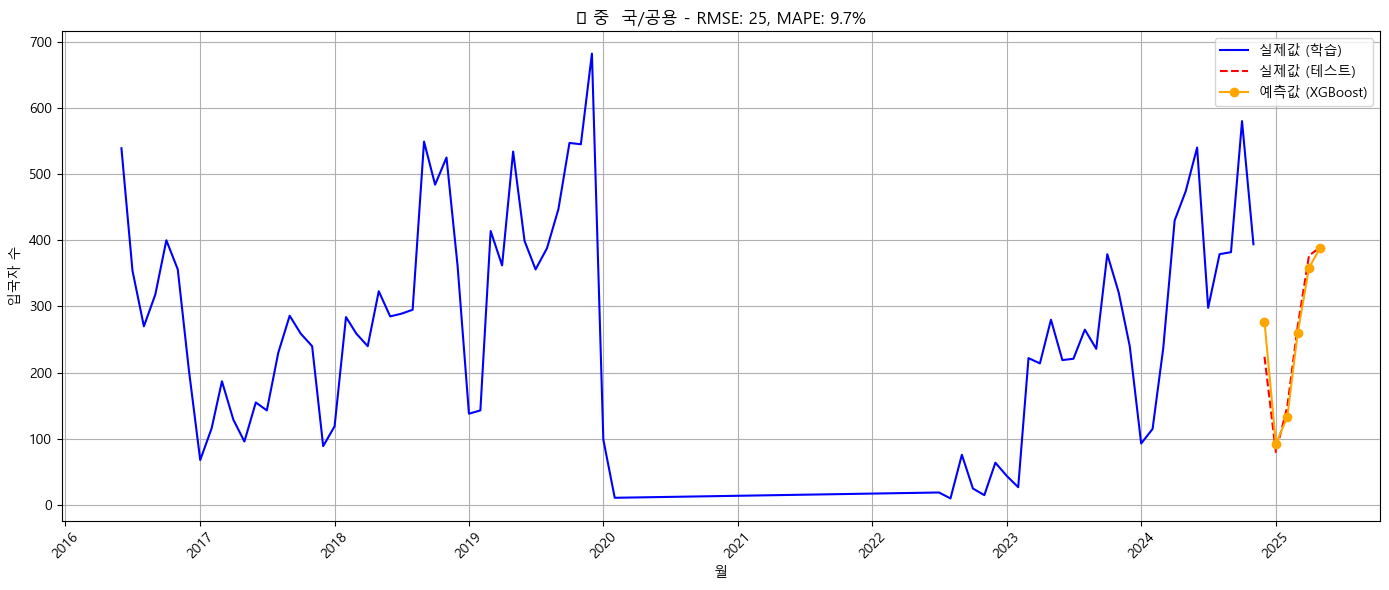

10:29:41 - cmdstanpy - INFO - Chain [1] start processing
10:29:42 - cmdstanpy - INFO - Chain [1] done processing


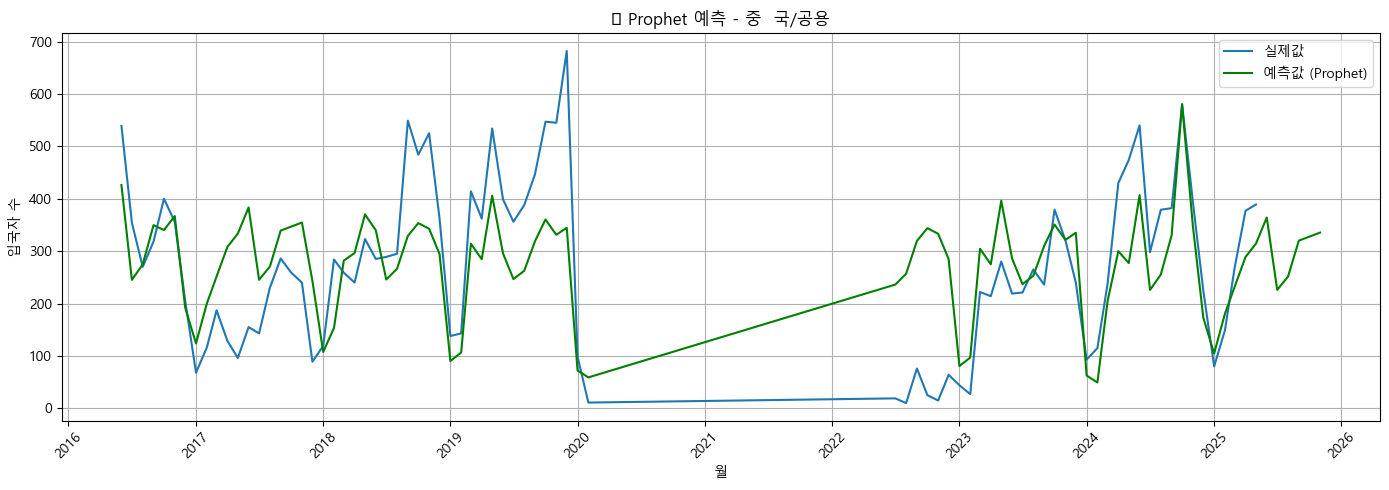


üìå ÏòàÏ∏° ÎåÄÏÉÅ: Ï§ë  Íµ≠ / Í¥ÄÍ¥ë (92 Í∞úÏõîÏπò)


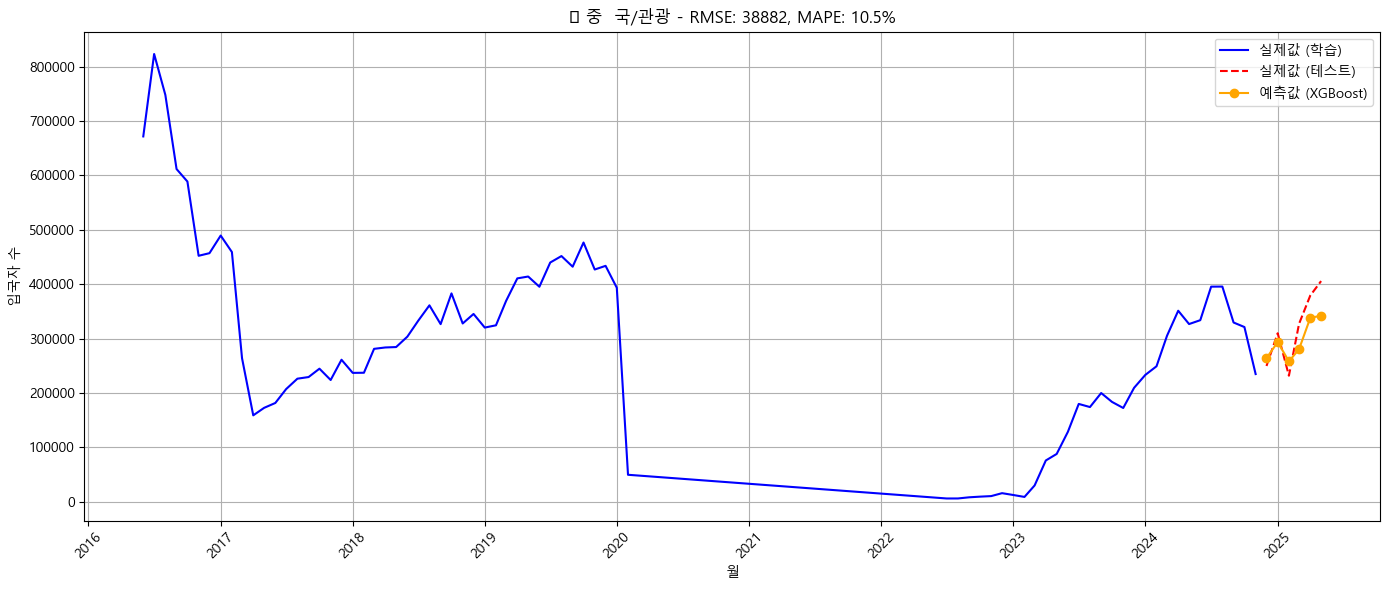

10:29:47 - cmdstanpy - INFO - Chain [1] start processing
10:29:47 - cmdstanpy - INFO - Chain [1] done processing


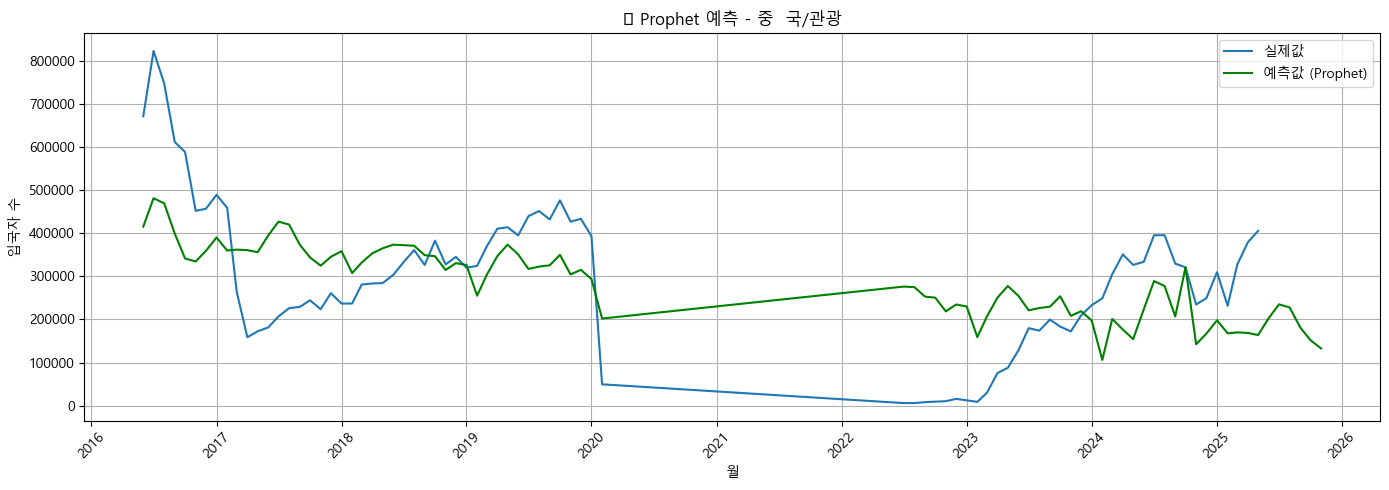


üìå ÏòàÏ∏° ÎåÄÏÉÅ: Ï§ë  Íµ≠ / Í∏∞ÌÉÄ (92 Í∞úÏõîÏπò)


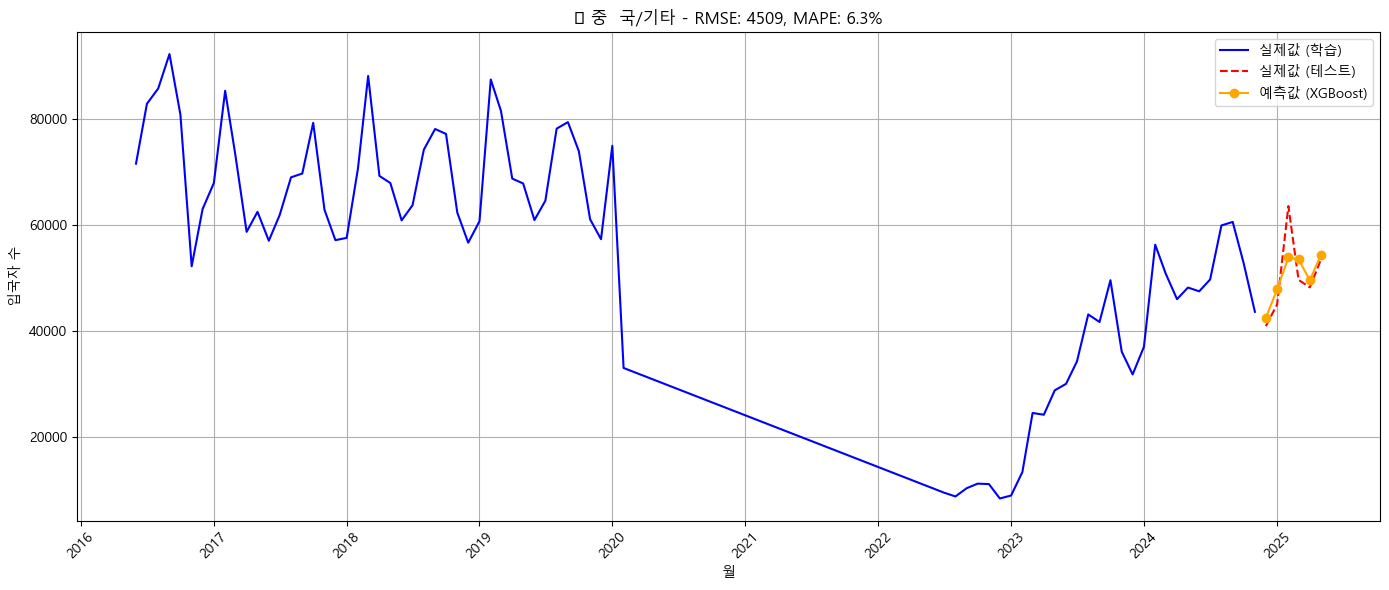

10:29:52 - cmdstanpy - INFO - Chain [1] start processing
10:29:53 - cmdstanpy - INFO - Chain [1] done processing


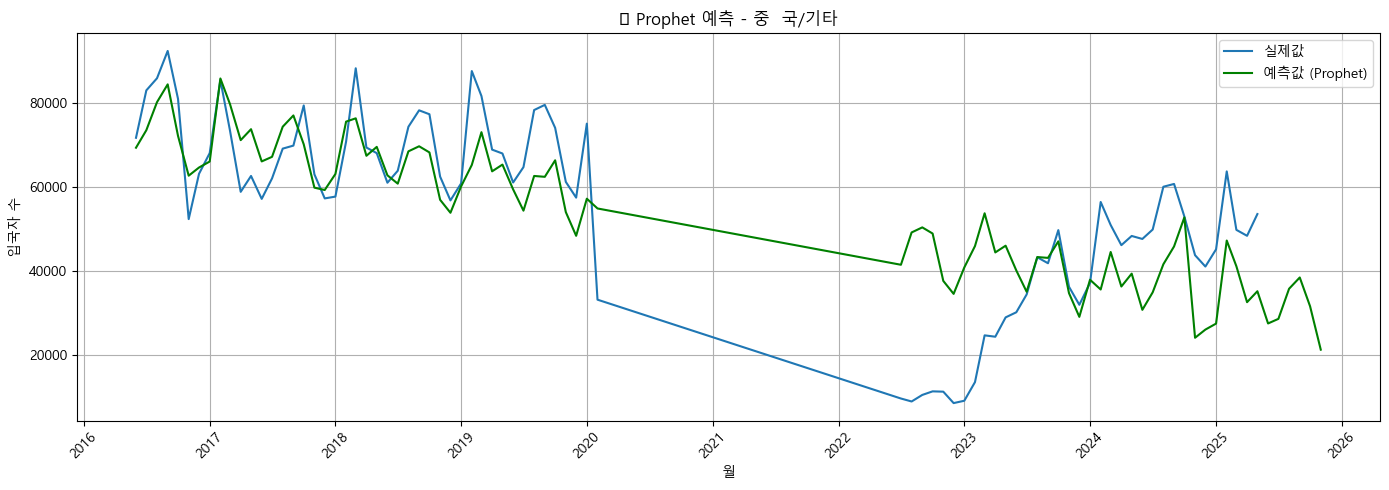


üìå ÏòàÏ∏° ÎåÄÏÉÅ: Ï§ë  Íµ≠ / ÏÉÅÏö© (92 Í∞úÏõîÏπò)


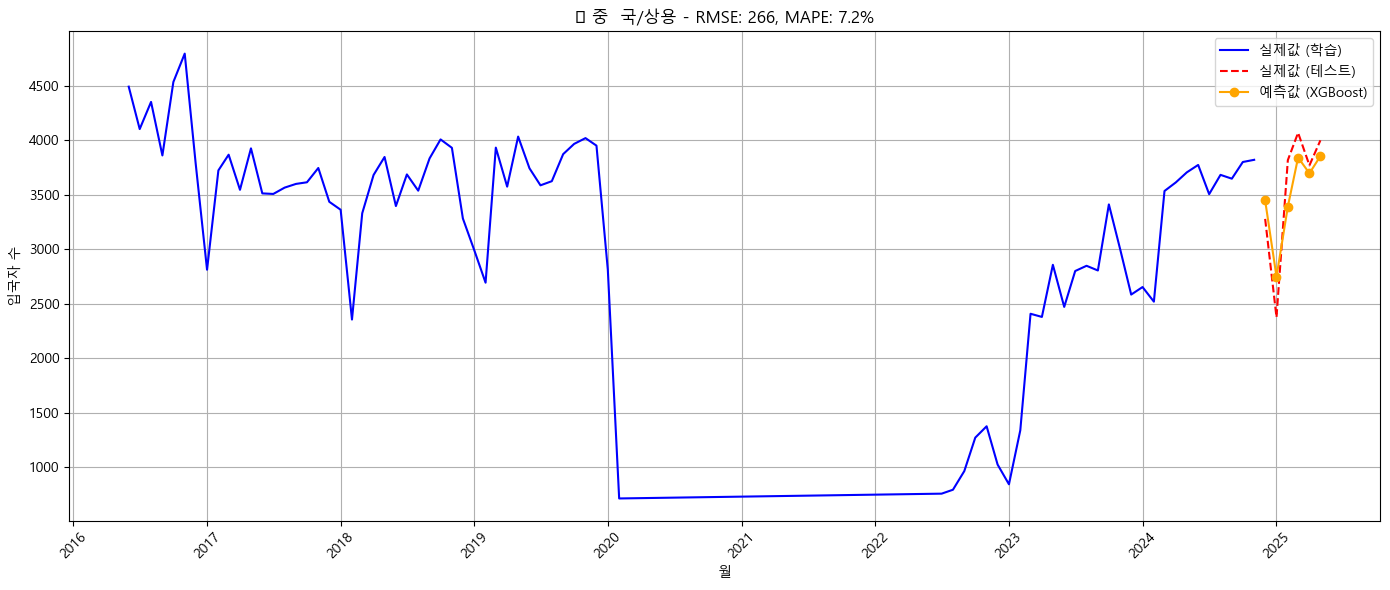

10:29:58 - cmdstanpy - INFO - Chain [1] start processing
10:29:58 - cmdstanpy - INFO - Chain [1] done processing


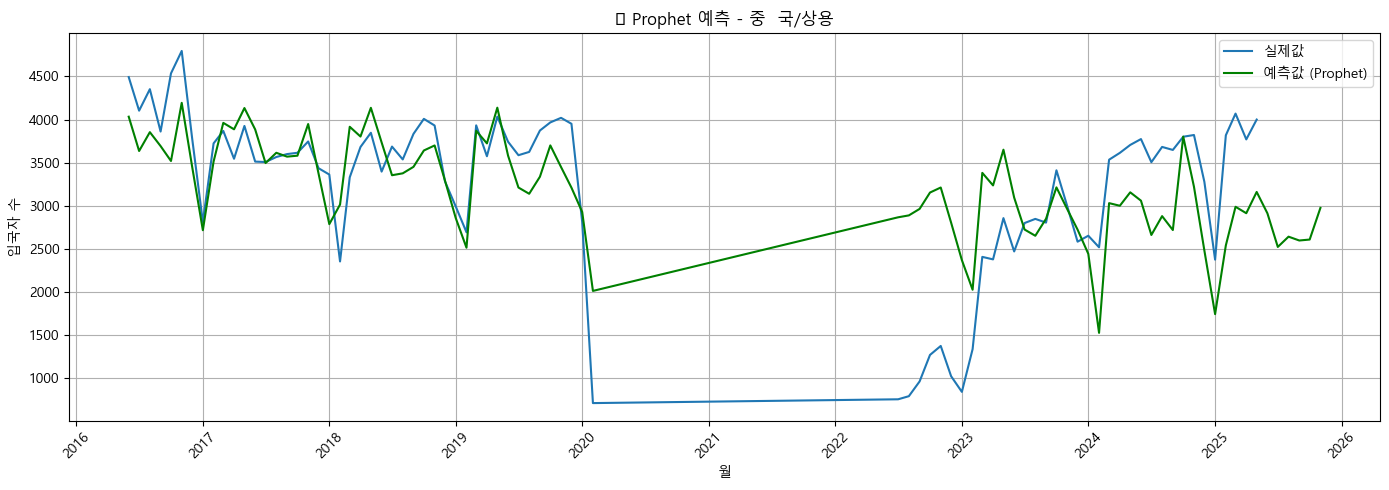


üìå ÏòàÏ∏° ÎåÄÏÉÅ: Ï§ë  Íµ≠ / Ïú†ÌïôÏó∞Ïàò (92 Í∞úÏõîÏπò)


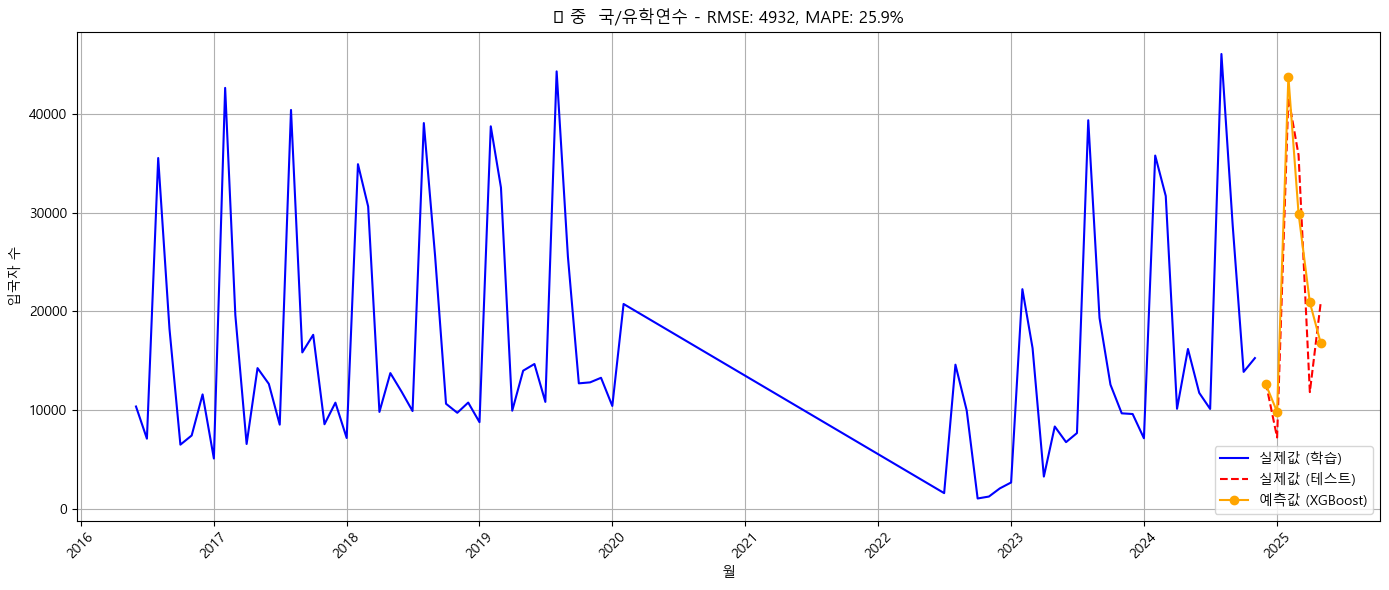

10:30:04 - cmdstanpy - INFO - Chain [1] start processing
10:30:05 - cmdstanpy - INFO - Chain [1] done processing


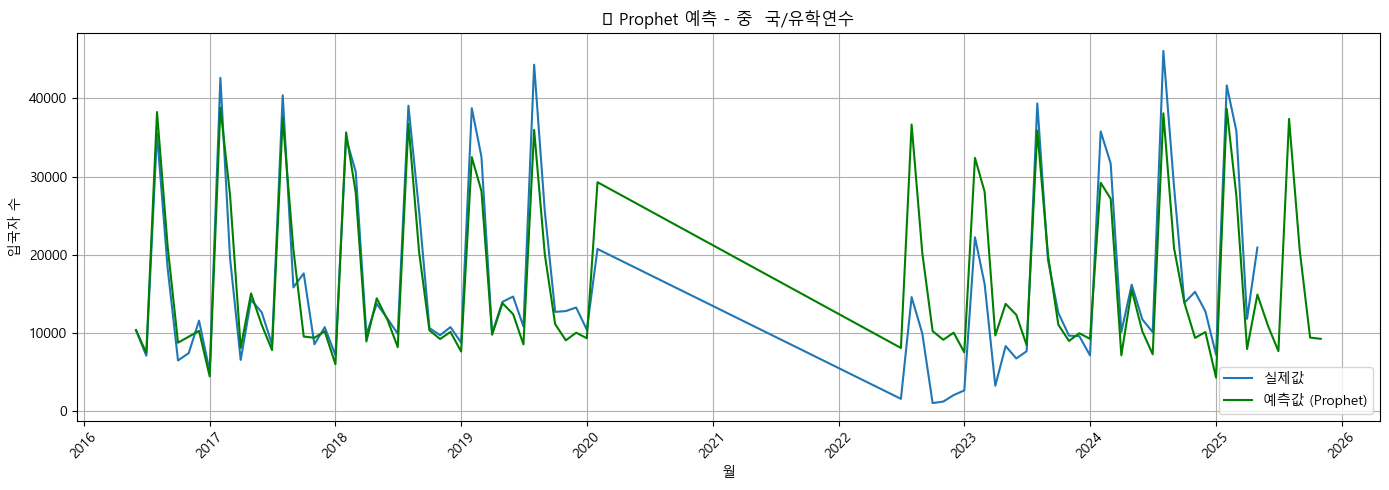

In [9]:
# CPU Ïù¥Ïö©
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib import rcParams

plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows ÌïúÍ∏Ä Ìè∞Ìä∏
plt.rcParams['axes.unicode_minus'] = False     # ÏùåÏàò Í∏∞Ìò∏ Íπ®Ïßê Î∞©ÏßÄ

# Î¨∏ÏûêÏó¥ Ï†ïÍ∑úÌôî Ìï®Ïàò
def normalize(text):
    return text.replace(" ", "").lower()

# [1] ÏÇ¨Ïö©Ïûê ÏûÖÎ†• Î∞è Ïú†ÏÇ¨ Îß§Ïπ≠
ÏÑ†ÌÉù_Íµ≠Ï†Å = input("ÏòàÏ∏°Ìï† Íµ≠Ï†Å ÏûÖÎ†• (Ï†ÑÏ≤¥ ÏòàÏ∏° ÏõêÌïòÎ©¥ Enter): ").strip()
ÏÑ†ÌÉù_Î™©Ï†Å = input("ÏòàÏ∏°Ìï† Î™©Ï†Å ÏûÖÎ†• (Ï†ÑÏ≤¥ ÏòàÏ∏° ÏõêÌïòÎ©¥ Enter): ").strip()

# [2] Îç∞Ïù¥ÌÑ∞ Î°úÎî© Î∞è Ï†ÑÏ≤òÎ¶¨
df = pd.read_csv('../1stProject/data/Î™©Ï†ÅÎ≥Ñ_Íµ≠Ï†ÅÎ≥Ñ_ÏûÖÍµ≠_ÏÜåÍ≥ÑÏ†úÍ±∞.csv', encoding='cp949')
df = df.melt(id_vars=["Íµ≠Ï†Å", "Î™©Ï†Å"], var_name="Ïõî", value_name="ÏûÖÍµ≠ÏûêÏàò")
df["Ïõî"] = pd.to_datetime(df["Ïõî"], format="%YÎÖÑ%mÏõî")
df["ÏûÖÍµ≠ÏûêÏàò"] = pd.to_numeric(df["ÏûÖÍµ≠ÏûêÏàò"].astype(str).str.replace(",", "", regex=False), errors="coerce")

# [3] Ïú†ÏÇ¨ Íµ≠Ï†Å/Î™©Ï†Å ÏûêÎèô ÏôÑÏÑ±
if ÏÑ†ÌÉù_Íµ≠Ï†Å:
    match = [nat for nat in df["Íµ≠Ï†Å"].dropna().unique()
             if isinstance(nat, str) and normalize(ÏÑ†ÌÉù_Íµ≠Ï†Å) in normalize(nat)]
    if match:
        ÏÑ†ÌÉù_Íµ≠Ï†Å = match[0]
        print(f"üëâ ÏûÖÎ†•Ìïú Íµ≠Ï†ÅÍ≥º Ïú†ÏÇ¨Ìïú Í∞íÏúºÎ°ú '{ÏÑ†ÌÉù_Íµ≠Ï†Å}' ÏÇ¨Ïö©")
    else:
        print("‚ùå Ïú†Ìö®Ìïú Íµ≠Ï†ÅÏù¥ ÏïÑÎãôÎãàÎã§."); ÏÑ†ÌÉù_Íµ≠Ï†Å = ""

if ÏÑ†ÌÉù_Î™©Ï†Å:
    match = [pur for pur in df["Î™©Ï†Å"].dropna().unique()
             if isinstance(pur, str) and normalize(ÏÑ†ÌÉù_Î™©Ï†Å) in normalize(pur)]
    if match:
        ÏÑ†ÌÉù_Î™©Ï†Å = match[0]
        print(f"üëâ ÏûÖÎ†•Ìïú Î™©Ï†ÅÍ≥º Ïú†ÏÇ¨Ìïú Í∞íÏúºÎ°ú '{ÏÑ†ÌÉù_Î™©Ï†Å}' ÏÇ¨Ïö©")
    else:
        print("‚ùå Ïú†Ìö®Ìïú Î™©Ï†ÅÏù¥ ÏïÑÎãôÎãàÎã§."); ÏÑ†ÌÉù_Î™©Ï†Å = ""

# [4] ÏòàÏ∏° ÎåÄÏÉÅ ÌïÑÌÑ∞ÎßÅ
targets = df.groupby(["Íµ≠Ï†Å", "Î™©Ï†Å"]).size().reset_index().rename(columns={0: "count"})
valid_targets = targets[targets['count'] > 24]
if ÏÑ†ÌÉù_Íµ≠Ï†Å:
    valid_targets = valid_targets[valid_targets["Íµ≠Ï†Å"] == ÏÑ†ÌÉù_Íµ≠Ï†Å]
if ÏÑ†ÌÉù_Î™©Ï†Å:
    valid_targets = valid_targets[valid_targets["Î™©Ï†Å"] == ÏÑ†ÌÉù_Î™©Ï†Å]

# [5] ÏòàÏ∏° Î£®ÌîÑ
for idx, row in valid_targets.iterrows():
    Íµ≠Ï†Å, Î™©Ï†Å = row["Íµ≠Ï†Å"], row["Î™©Ï†Å"]
    df_filtered = df[(df["Íµ≠Ï†Å"] == Íµ≠Ï†Å) & (df["Î™©Ï†Å"] == Î™©Ï†Å)].sort_values("Ïõî").reset_index(drop=True)

    if len(df_filtered) < 30:
        continue
    print(f"\nüìå ÏòàÏ∏° ÎåÄÏÉÅ: {Íµ≠Ï†Å} / {Î™©Ï†Å} ({len(df_filtered)} Í∞úÏõîÏπò)")

    # ÌååÏÉù Î≥ÄÏàò ÏÉùÏÑ±
    df_filtered["Ïó∞ÎèÑ"] = df_filtered["Ïõî"].dt.year
    df_filtered["Ïõî_Ïà´Ïûê"] = df_filtered["Ïõî"].dt.month
    df_filtered["Í≥ÑÏ†à"] = df_filtered["Ïõî"].dt.month % 12 // 3
    df_filtered["Ï†ÑÏõîÏûÖÍµ≠ÏûêÏàò"] = df_filtered["ÏûÖÍµ≠ÏûêÏàò"].shift(1)
    df_filtered["Ï†ÑÎÖÑÎèôÏõîÏûÖÍµ≠ÏûêÏàò"] = df_filtered["ÏûÖÍµ≠ÏûêÏàò"].shift(12)
    df_filtered["Ï†ÑÏõîÏ¶ùÍ∞êÎ•†"] = df_filtered["ÏûÖÍµ≠ÏûêÏàò"].pct_change().shift(1)
    df_filtered["Ï†ÑÎÖÑÏ¶ùÍ∞êÎ•†"] = (df_filtered["ÏûÖÍµ≠ÏûêÏàò"] - df_filtered["ÏûÖÍµ≠ÏûêÏàò"].shift(12)) / df_filtered["ÏûÖÍµ≠ÏûêÏàò"].shift(12)
    df_filtered["Ïù¥ÎèôÌèâÍ∑†3"] = df_filtered["ÏûÖÍµ≠ÏûêÏàò"].rolling(window=3).mean().shift(1)
    df_filtered["Ïù¥ÎèôÌèâÍ∑†6"] = df_filtered["ÏûÖÍµ≠ÏûêÏàò"].rolling(window=6).mean().shift(1)
    df_filtered["Ï†ÑÏõî_Ï∞®Ïù¥"] = df_filtered["ÏûÖÍµ≠ÏûêÏàò"] - df_filtered["Ï†ÑÏõîÏûÖÍµ≠ÏûêÏàò"]
    df_filtered["Ï†ÑÎÖÑ_Ï∞®Ïù¥"] = df_filtered["ÏûÖÍµ≠ÏûêÏàò"] - df_filtered["Ï†ÑÎÖÑÎèôÏõîÏûÖÍµ≠ÏûêÏàò"]
    df_filtered["Ïó∞Ï§ëÎàÑÏ†ÅÌï©"] = df_filtered.groupby("Ïó∞ÎèÑ")["ÏûÖÍµ≠ÏûêÏàò"].cumsum()
    df_filtered = df_filtered.replace([np.inf, -np.inf], np.nan).dropna().copy()

    if df_filtered.empty:
        continue

    # ÌäπÏßï Î∞è ÌÉÄÍ≤ü
    features = ["Ïó∞ÎèÑ", "Ïõî_Ïà´Ïûê", "Í≥ÑÏ†à", "Ï†ÑÏõîÏûÖÍµ≠ÏûêÏàò", "Ï†ÑÎÖÑÎèôÏõîÏûÖÍµ≠ÏûêÏàò",
                "Ï†ÑÏõîÏ¶ùÍ∞êÎ•†", "Ï†ÑÎÖÑÏ¶ùÍ∞êÎ•†", "Ïù¥ÎèôÌèâÍ∑†3", "Ïù¥ÎèôÌèâÍ∑†6",
                "Ï†ÑÏõî_Ï∞®Ïù¥", "Ï†ÑÎÖÑ_Ï∞®Ïù¥", "Ïó∞Ï§ëÎàÑÏ†ÅÌï©"]
    X = df_filtered[features]
    y = df_filtered["ÏûÖÍµ≠ÏûêÏàò"]
    dates = df_filtered["Ïõî"]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # ÌïôÏäµ/ÌÖåÏä§Ìä∏ Î∂ÑÎ¶¨
    X_train, X_test = X_scaled[:-6], X_scaled[-6:]
    y_train, y_test = y[:-6], y[-6:]
    dates_train, dates_test = dates[:-6], dates[-6:]

    if len(X_test) == 0:
        continue

    # CPU Í∏∞Î∞ò XGBoost Î™®Îç∏
    xgb = XGBRegressor(random_state=42)
    param_dist = {
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }
    search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=10,
                                 cv=TimeSeriesSplit(n_splits=3),
                                 scoring='neg_root_mean_squared_error', random_state=42)
    search.fit(X_train, y_train)
    best_model = search.best_estimator_

    y_pred = np.clip(best_model.predict(X_test), 0, None)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100

    # ÏãúÍ∞ÅÌôî
    plt.figure(figsize=(14, 6))
    plt.plot(dates_train, y_train, label="Ïã§Ï†úÍ∞í (ÌïôÏäµ)", color='blue')
    plt.plot(dates_test, y_test, label="Ïã§Ï†úÍ∞í (ÌÖåÏä§Ìä∏)", color='red', linestyle='--')
    plt.plot(dates_test, y_pred, label="ÏòàÏ∏°Í∞í (XGBoost)", color='orange', marker='o')
    plt.title(f"üìä {Íµ≠Ï†Å}/{Î™©Ï†Å} - RMSE: {rmse:.0f}, MAPE: {mape:.1f}%")
    plt.xlabel("Ïõî")
    plt.ylabel("ÏûÖÍµ≠Ïûê Ïàò")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Prophet ÏãúÍ≥ÑÏó¥ ÏòàÏ∏°
    df_prophet = df_filtered[["Ïõî", "ÏûÖÍµ≠ÏûêÏàò"]].rename(columns={"Ïõî": "ds", "ÏûÖÍµ≠ÏûêÏàò": "y"})
    prophet = Prophet(yearly_seasonality=True)
    try:
        prophet.add_country_holidays(country_name='KR')
        prophet.fit(df_prophet)
        future = prophet.make_future_dataframe(periods=6, freq='MS')
        forecast = prophet.predict(future)

        plt.figure(figsize=(14, 5))
        plt.plot(df_prophet['ds'], df_prophet['y'], label='Ïã§Ï†úÍ∞í')
        plt.plot(forecast['ds'], forecast['yhat'], label='ÏòàÏ∏°Í∞í (Prophet)', color='green')
        plt.title(f"üîÆ Prophet ÏòàÏ∏° - {Íµ≠Ï†Å}/{Î™©Ï†Å}")
        plt.xlabel("Ïõî")
        plt.ylabel("ÏûÖÍµ≠Ïûê Ïàò")
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"[Prophet Ïò§Î•ò] {Íµ≠Ï†Å}/{Î™©Ï†Å}: {e}")


In [10]:
# Ï∂îÍ∞Ä